# AD 3D CNN - ROI Attention (해부학적 좌표 고정)

CN vs (MCI+AD) 이진분류를 위한 3D CNN 모델입니다.

**ROI 좌표 설정 가이드:**
- TARGET_SHAPE: (96, 112, 96) 기준
- RAS+ orientation (Right-Anterior-Superior positive)
- D축(depth): Inferior(0) → Superior(95)
- H축(height): Posterior(0) → Anterior(111)  
- W축(width): Left(0) → Right(95)

In [1]:
import random
from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tqdm import tqdm

In [ ]:
# Google Colab 사용 시 주석 해제
"""from google.colab import drive
drive.mount('/content/drive')
    DATA_DIR = Path("/content/drive/MyDrive/7조 장뇌삼/최종프로젝트/데이터셋/mri_robust")
    METADATA_PATH = Path("/content/drive/MyDrive/7조 장뇌삼/최종프로젝트/데이터셋/idaSearch_image_download_metadata_2510.csv")
    OUTPUT_DIR = Path("/content/drive/MyDrive/7조 장뇌삼/최종프로젝트/마찬호/13")"""

Mounted at /content/drive


---
## 🔧 설정 (Config)

모든 하이퍼파라미터와 경로를 여기서 관리합니다.

In [ ]:
basic = "basic"
attention = "attention"
transformer = "transformer"
lstm = "lstm"
gru = "gru"
translstm = "translstm"
transgru = "transgru"

class Config:
    # =====================================================
    # 📁 PATHS - 데이터 경로 설정
    # =====================================================
    DATA_DIR = Path("/Users/machanho/Desktop/uv/ad/7.data_mci,ad")
    METADATA_PATH = Path("/Users/machanho/Desktop/uv/ad/idaSearch_image_download_metadata_2510.csv")
    OUTPUT_DIR = Path("/Users/machanho/Desktop/uv/ad/13")

    # =====================================================
    # 🎲 SEED / SPLIT
    # =====================================================
    SEED = 42
    TEST_SIZE = 0.1
    VAL_SIZE = 0.1

    # =====================================================
    # 📊 DATA
    # =====================================================
    TARGET_SHAPE = (96, 112, 96)  # (D, H, W)
    NUM_CLASSES = 2
    CLASS_NAMES = ["CN", "CI"]

    # =====================================================
    # 🏋️ TRAINING
    # =====================================================
    BATCH_SIZE = 4
    EPOCHS = 10
    LR = 1e-4
    GRAD_ACCUM_STEPS = 4  # effective batch = 16
    EARLY_STOP_PATIENCE = 20
    USE_WEIGHTED_SAMPLER = True

    # =====================================================
    # 🧠 MODEL
    # =====================================================
    MODEL_NAME = "attention"  # "basic" | "attention" | "transformer" | "lstm" | "gru" | "translstm" | "transgru"
    DROPOUT = 0.25

    # =====================================================
    # 💻 DEVICE
    # =====================================================
    @staticmethod
    def get_device():
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

    DEVICE = None  # 아래에서 설정
    NUM_WORKERS = 4

Config.DEVICE = Config.get_device()

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(f"Using device: {Config.DEVICE}")

Using device: cuda


---
## 🎯 ROI 설정 (Region of Interest)

해부학적 위치에 기반한 ROI 가중치 설정입니다.  
**여기서 좌표를 수정**하면 됩니다.

### 좌표계 설명 (TARGET_SHAPE = 96 x 112 x 96)

```
RAS+ Orientation (MNI space 기준 정규화 후)

D축 [0-95]:  Inferior(아래) → Superior(위)     | 중앙: 48
H축 [0-111]: Posterior(뒤)  → Anterior(앞)    | 중앙: 56  
W축 [0-95]:  Left(좌)       → Right(우)       | 중앙: 48
```

### 가중치 가이드
| 가중치 | 의미 |
|--------|------|
| 1.0 | 기본 (강조 없음) |
| 1.3 | 약간 강조 |
| 1.5 | 중간 강조 |
| 1.8 | 강한 강조 |
| 2.0+ | 매우 강한 강조 |

### 이진분류 참고 (CN vs MCI+AD)
- **CN vs MCI**: 해마, 엔토라이날 피질 초기 변화가 핵심 (MCI 탐지)
- **MCI/AD**: 측두엽, 두정엽으로의 확장 위축 패턴
- **CN vs Impaired**: 전체적인 뇌 위축 + 뇌실 확장 (진행된 손상)

In [4]:
class ROIConfig:
    """
    🎯 ROI 가중치 설정

    각 ROI의 center는 [D, H, W] 순서입니다.
    sigma: Gaussian 분포의 표준편차 (클수록 넓은 영역에 영향)
    weight: 해당 영역의 가중치 배수

    💡 수정 방법:
    1. center 좌표 조정: 영역의 중심 위치 변경
    2. sigma 조정: 영역의 크기 변경
    3. weight 조정: 해당 영역의 중요도 변경
    4. ROI 추가/제거: 딕셔너리에 항목 추가/삭제
    """

    # ROI Attention 사용 여부
    USE_ROI_ATTENTION = True

    # 기본 가중치 (ROI 외 영역)
    BASE_WEIGHT = 1.0

    # =========================================================
    # 🧠 ROI 정의
    # =========================================================
    # 좌표: [D(Inf→Sup), H(Post→Ant), W(Left→Right)]
    # TARGET_SHAPE = (96, 112, 96) 기준
    # =========================================================

    ROI_DEFINITIONS = {
        # ===========================================================
        # A. 내측 측두엽 (MTL) - MCI 초기 핵심 바이오마커
        # ===========================================================
        # 해마 (Hippocampus)
        "hippocampus_L": {
            "center": [48, 54, 36],
            "sigma": 4.0,
            "weight": 2.0,
            "description": "좌측 해마 - MCI/AD 핵심"
        },
        "hippocampus_R": {
            "center": [48, 54, 60],
            "sigma": 4.0,
            "weight": 2.0,
            "description": "우측 해마"
        },

        # 엔토라이날 피질 (Entorhinal Cortex) - MCI 최초 변화
        "entorhinal_L": {
            "center": [54, 48, 34],
            "sigma": 3.5,
            "weight": 2.0,
            "description": "좌측 엔토라이날 - MCI 초기"
        },
        "entorhinal_R": {
            "center": [54, 48, 62],
            "sigma": 3.5,
            "weight": 2.0,
            "description": "우측 엔토라이날"
        },

        # 해마방회 (Parahippocampal Gyrus)
        "parahippocampal_L": {
            "center": [48, 42, 32],
            "sigma": 4.0,
            "weight": 1.6,
            "description": "좌측 해마방회"
        },
        "parahippocampal_R": {
            "center": [48, 42, 64],
            "sigma": 4.0,
            "weight": 1.6,
            "description": "우측 해마방회"
        },

        # 편도체 (Amygdala)
        "amygdala_L": {
            "center": [42, 60, 34],
            "sigma": 3.5,
            "weight": 1.5,
            "description": "좌측 편도체"
        },
        "amygdala_R": {
            "center": [42, 60, 62],
            "sigma": 3.5,
            "weight": 1.5,
            "description": "우측 편도체"
        },

        # ===========================================================
        # B. AD signature + 연관 피질 영역 (확장성 위축)
        # ===========================================================
        # 후대상피질 (Posterior Cingulate Cortex)
        "posterior_cingulate": {
            "center": [30, 35, 48],
            "sigma": 5.0,
            "weight": 1.4,
            "description": "후대상피질 - AD 확장 패턴"
        },

        # 쐐기앞소엽 (Precuneus)
        "precuneus": {
            "center": [65, 30, 48],
            "sigma": 6.0,
            "weight": 1.4,
            "description": "precuneus - AD 확장 패턴"
        },

        # Inferior / Middle Temporal + Fusiform (AD signature)
        "inferior_temporal_L": {
            "center": [42, 60, 22],
            "sigma": 8.0,
            "weight": 1.3,
            "description": "좌측 하측두회"
        },
        "inferior_temporal_R": {
            "center": [42, 60, 72],
            "sigma": 8.0,
            "weight": 1.3,
            "description": "우측 하측두회"
        },
        "middle_temporal_L": {
            "center": [48, 52, 24],
            "sigma": 8.0,
            "weight": 1.3,
            "description": "좌측 중측두회"
        },
        "middle_temporal_R": {
            "center": [48, 52, 72],
            "sigma": 8.0,
            "weight": 1.3,
            "description": "우측 중측두회"
        },
        "fusiform_L": {
            "center": [38, 58, 28],
            "sigma": 6.0,
            "weight": 1.3,
            "description": "좌측 방추상회"
        },
        "fusiform_R": {
            "center": [38, 58, 68],
            "sigma": 6.0,
            "weight": 1.3,
            "description": "우측 방추상회"
        },

        # 두정엽 (Parietal Cortex)
        "parietal_L": {
            "center": [68, 45, 26],
            "sigma": 8.0,
            "weight": 1.2,
            "description": "좌측 두정엽 - temporo-parietal 확장"
        },
        "parietal_R": {
            "center": [68, 45, 70],
            "sigma": 8.0,
            "weight": 1.2,
            "description": "우측 두정엽"
        },

        # 전두엽 (Frontal Cortex) - 후기 확장
        "frontal": {
            "center": [55, 85, 48],
            "sigma": 10.0,
            "weight": 1.1,
            "description": "전두엽 - 후기 확장"
        },

        # ===========================================================
        # C. 뇌실 (Ventricles) - 위축 보상 지표
        # ===========================================================
        "lateral_ventricle": {
            "center": [35, 56, 48],
            "sigma": 12.0,
            "weight": 1.5,
            "description": "측뇌실 - 위축 보상 확장"
        },
        "inferior_horn_L": {
            "center": [35, 56, 30],
            "sigma": 8.0,
            "weight": 1.5,
            "description": "좌측 하각 - 해마 위축 지표"
        },
        "inferior_horn_R": {
            "center": [35, 56, 66],
            "sigma": 8.0,
            "weight": 1.5,
            "description": "우측 하각"
        },
    }

    @classmethod
    def get_roi_summary(cls):
        """ROI 설정 요약 출력"""
        print("=" * 70)
        print("🎯 ROI Configuration Summary")
        print("=" * 70)
        print(f"USE_ROI_ATTENTION: {cls.USE_ROI_ATTENTION}")
        print(f"BASE_WEIGHT: {cls.BASE_WEIGHT}")
        print(f"Number of ROIs: {len(cls.ROI_DEFINITIONS)}")
        print("-" * 70)
        print(f"{'Name':<25} {'Center [D,H,W]':<20} {'σ':<8} {'Weight':<8}")
        print("-" * 70)
        for name, roi in cls.ROI_DEFINITIONS.items():
            center_str = str(roi['center'])
            print(f"{name:<25} {center_str:<20} {roi['sigma']:<8.1f} {roi['weight']:<8.2f}")
        print("=" * 70)

In [5]:
# 설정 확인
print("=" * 70)
print("CONFIGURATION SUMMARY")
print("=" * 70)
print(f"Device: {Config.DEVICE}")
print(f"Model: {Config.MODEL_NAME}")
print(f"Target shape: {Config.TARGET_SHAPE}")
print(f"Classes: {Config.CLASS_NAMES} (3-class classification)")
print(f"Batch size: {Config.BATCH_SIZE} x {Config.GRAD_ACCUM_STEPS} = {Config.BATCH_SIZE * Config.GRAD_ACCUM_STEPS} (effective)")
print(f"Output dir: {Config.OUTPUT_DIR}")
print("=" * 70)

ROIConfig.get_roi_summary()

CONFIGURATION SUMMARY
Device: cuda
Model: attention
Target shape: (96, 112, 96)
Classes: ['CN', 'CI'] (3-class classification)
Batch size: 32 x 4 = 128 (effective)
Output dir: /content/drive/MyDrive/7조 장뇌삼/최종프로젝트/마찬호/13
🎯 ROI Configuration Summary
USE_ROI_ATTENTION: True
BASE_WEIGHT: 1.0
Number of ROIs: 22
----------------------------------------------------------------------
Name                      Center [D,H,W]       σ        Weight  
----------------------------------------------------------------------
hippocampus_L             [48, 54, 36]         4.0      2.00    
hippocampus_R             [48, 54, 60]         4.0      2.00    
entorhinal_L              [54, 48, 34]         3.5      2.00    
entorhinal_R              [54, 48, 62]         3.5      2.00    
parahippocampal_L         [48, 42, 32]         4.0      1.60    
parahippocampal_R         [48, 42, 64]         4.0      1.60    
amygdala_L                [42, 60, 34]         3.5      1.50    
amygdala_R  

---
## 📊 데이터 인덱싱 / 분할

In [6]:
_SUBJECT_RE = re.compile(r"__([0-9]{3}_S_[0-9]+)__")
_SUBJECT_FALLBACK_RE = re.compile(r"([0-9]{3}_S_[0-9]+)")


@dataclass(frozen=True)
class SplitConfig:
    seed: int = Config.SEED
    test_size: float = Config.TEST_SIZE
    val_size: float = Config.VAL_SIZE


def _extract_subject_id(name: str) -> str | None:
    match = _SUBJECT_RE.search(name)
    if match:
        return match.group(1)
    match = _SUBJECT_FALLBACK_RE.search(name)
    if match:
        return match.group(1)
    return None


def build_index(
    data_dir: Path,
    metadata_csv: Path,
) -> pd.DataFrame:
    if not data_dir.exists():
        raise FileNotFoundError(f"data_dir not found: {data_dir}")
    if not metadata_csv.exists():
        raise FileNotFoundError(f"metadata_csv not found: {metadata_csv}")

    meta = pd.read_csv(metadata_csv)
    meta = meta[["Subject ID", "Research Group"]].dropna()
    meta = meta.drop_duplicates(subset=["Subject ID"], keep="last")

    group_map = {"CN": 0, "MCI": 1, "AD": 1}

    rows = []
    for path in sorted(data_dir.glob("*.nii*")):
        subject_id = _extract_subject_id(path.name)
        if not subject_id:
            continue
        row = meta.loc[meta["Subject ID"] == subject_id]
        if row.empty:
            continue
        group = row.iloc[0]["Research Group"]
        if group not in group_map:
            continue
        label = group_map[group]
        rows.append(
            {
                "path": str(path),
                "subject_id": subject_id,
                "group": group,
                "label": label,
            }
        )

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("No matching files found for metadata and data_dir.")
    return df


def split_by_subject(df: pd.DataFrame, config: SplitConfig) -> dict[str, pd.DataFrame]:
    from sklearn.model_selection import train_test_split

    subject_df = df.drop_duplicates(subset=["subject_id"])[["subject_id", "label"]]
    subjects = subject_df["subject_id"].tolist()
    labels = subject_df["label"].tolist()

    train_subjects, test_subjects = train_test_split(
        subjects,
        test_size=config.test_size,
        random_state=config.seed,
        stratify=labels,
    )

    train_labels = [
        subject_df.loc[subject_df["subject_id"] == sid, "label"].iloc[0]
        for sid in train_subjects
    ]
    train_subjects, val_subjects = train_test_split(
        train_subjects,
        test_size=config.val_size,
        random_state=config.seed,
        stratify=train_labels,
    )

    def _select(subject_list: list[str]) -> pd.DataFrame:
        return df[df["subject_id"].isin(subject_list)].reset_index(drop=True)

    return {
        "train": _select(train_subjects),
        "val": _select(val_subjects),
        "test": _select(test_subjects),
    }

---
## 📦 Dataset

In [7]:
def _normalize(volume: np.ndarray) -> np.ndarray:
    v = volume.astype(np.float32)
    lo, hi = np.percentile(v, (1, 99))
    if hi <= lo:
        lo, hi = v.min(), v.max()
    if hi <= lo:
        return np.zeros_like(v, dtype=np.float32)
    v = np.clip((v - lo) / (hi - lo), 0, 1)
    return v.astype(np.float32)


def _resize_tensor(volume: torch.Tensor, target_shape: tuple[int, int, int]) -> torch.Tensor:
    vol = volume.unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
    vol = F.interpolate(vol, size=target_shape, mode="trilinear", align_corners=False)
    return vol.squeeze(0)  # (1, D, H, W)


class NiftiDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        target_shape: tuple[int, int, int] = (96, 112, 96),
        augment: bool = False,
    ) -> None:
        self.df = df.reset_index(drop=True)
        self.target_shape = target_shape
        self.augment = augment

    def __len__(self) -> int:
        return len(self.df)

    def _augment(self, volume: torch.Tensor) -> torch.Tensor:
        # Intensity augmentation
        if torch.rand(1).item() < 0.3:
            volume = volume * (0.9 + 0.2 * torch.rand(1).item())  # brightness
        if torch.rand(1).item() < 0.3:
            volume = volume + (torch.rand(1).item() - 0.5) * 0.1  # shift
        volume = torch.clamp(volume, 0, 1)
        return volume

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        import nibabel as nib

        row = self.df.iloc[idx]
        path = row["path"]
        try:
            img = nib.load(path)
            data = img.get_fdata()
            if data.ndim == 4:
                data = data[..., 0]
            if data.ndim != 3:
                raise ValueError(f"Unexpected NIfTI shape {data.shape}")
            data = _normalize(data)
            vol = torch.from_numpy(data)
            vol = _resize_tensor(vol, self.target_shape)
        except Exception as exc:
            raise RuntimeError(f"Failed to load/prepare NIfTI: {path}") from exc
        if self.augment:
            vol = self._augment(vol)
        label = int(row["label"])
        return vol, label

---
## 🧠 모델

In [8]:
# ============================================================
# ROI Spatial Attention Module
# ============================================================

def create_roi_weight_map(
    target_shape: tuple[int, int, int],
    roi_definitions: dict,
    base_weight: float = ROIConfig.BASE_WEIGHT
) -> torch.Tensor:
    """
    ROI 기반 3D 가중치 맵 생성

    각 ROI는 3D Gaussian으로 모델링되며, 중첩 영역은 가중치가 합산됩니다.
    """
    D, H, W = target_shape
    weight_map = torch.ones(1, 1, D, H, W) * base_weight

    d = torch.arange(D).float()
    h = torch.arange(H).float()
    w = torch.arange(W).float()
    dd, hh, ww = torch.meshgrid(d, h, w, indexing='ij')

    for name, roi in roi_definitions.items():
        center = roi["center"]
        sigma = roi["sigma"]
        roi_weight = roi["weight"]

        dist_sq = ((dd - center[0])**2 + (hh - center[1])**2 + (ww - center[2])**2)
        gaussian = torch.exp(-dist_sq / (2 * sigma**2))
        weight_map[0, 0] += gaussian * max(0.0, roi_weight - base_weight)

    return weight_map


class ROISpatialAttention(nn.Module):
    """
    입력 볼륨에 ROI 기반 공간 가중치를 적용하는 모듈
    """
    def __init__(
        self,
        target_shape: tuple[int, int, int],
        roi_definitions: dict,
        base_weight: float = ROIConfig.BASE_WEIGHT
    ):
        super().__init__()
        weight_map = create_roi_weight_map(target_shape, roi_definitions, base_weight)
        self.register_buffer('weight_map', weight_map)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weight_map


def build_roi_attention(config: type, roi_config: type) -> ROISpatialAttention | None:
    """
    ROI Attention 모듈 생성
    """
    if not roi_config.USE_ROI_ATTENTION:
        return None

    return ROISpatialAttention(
        target_shape=config.TARGET_SHAPE,
        roi_definitions=roi_config.ROI_DEFINITIONS,
        base_weight=roi_config.BASE_WEIGHT,
    )

In [9]:
# ============================================================
# Model Building Blocks
# ============================================================

class ConvBlock3D(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int = 8) -> None:
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y

In [10]:

# ============================================================
# Models
# ============================================================

class MCIClassifier3D(nn.Module):
    """Basic 3D CNN for MCI classification"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, 256),
        )
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)
        x = self.encoder(x)
        x = self.pool(x)
        return self.classifier(x)


class MCIClassifierWithAttention(nn.Module):
    """3D CNN with Channel Attention"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.block1 = ConvBlock3D(1, 32)
        self.block2 = ConvBlock3D(32, 64)
        self.block3 = ConvBlock3D(64, 128)
        self.block4 = ConvBlock3D(128, 256)
        self.attn = ChannelAttention(256)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.attn(x)
        x = self.pool(x)
        return self.classifier(x)


class MCIClassifierCNNTransformer(nn.Module):
    """3D CNN encoder + Transformer encoder classifier"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None,
        embed_dim: int = 256,
        num_heads: int = 8,
        num_layers: int = 2,
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, embed_dim),
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    @staticmethod
    def _sinusoidal_positional_encoding(
        seq_len: int,
        embed_dim: int,
        device: torch.device,
        dtype: torch.dtype,
    ) -> torch.Tensor:
        position = torch.arange(seq_len, device=device, dtype=dtype).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2, device=device, dtype=dtype)
            * (-torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / embed_dim)
        )
        pe = torch.zeros(seq_len, embed_dim, device=device, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)

        x = self.encoder(x)
        b, c, d, h, w = x.shape

        tokens = x.flatten(2).transpose(1, 2)  # [B, D*H*W, C]
        cls_tokens = self.cls_token.expand(b, -1, -1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)

        pos = self._sinusoidal_positional_encoding(
            seq_len=tokens.size(1),
            embed_dim=tokens.size(2),
            device=tokens.device,
            dtype=tokens.dtype,
        )
        tokens = self.dropout(tokens + pos.unsqueeze(0))

        encoded = self.transformer(tokens)
        cls_repr = self.norm(encoded[:, 0])
        return self.classifier(cls_repr)



class MCIClassifierTransLSTM(nn.Module):
    """3D CNN encoder + Transformer + LSTM classifier"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None,
        embed_dim: int = 256,
        num_heads: int = 8,
        num_layers: int = 2,
        lstm_hidden_dim: int = 128,
        lstm_layers: int = 2,
        bidirectional: bool = True,
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.bidirectional = bidirectional
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, embed_dim),
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            dropout=dropout if lstm_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        lstm_out_dim = lstm_hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_out_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    @staticmethod
    def _sinusoidal_positional_encoding(
        seq_len: int,
        embed_dim: int,
        device: torch.device,
        dtype: torch.dtype,
    ) -> torch.Tensor:
        position = torch.arange(seq_len, device=device, dtype=dtype).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2, device=device, dtype=dtype)
            * (-torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / embed_dim)
        )
        pe = torch.zeros(seq_len, embed_dim, device=device, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)

        x = self.encoder(x)
        seq = x.mean(dim=(3, 4)).transpose(1, 2)  # [B, D, C]
        pos = self._sinusoidal_positional_encoding(
            seq_len=seq.size(1),
            embed_dim=seq.size(2),
            device=seq.device,
            dtype=seq.dtype,
        )
        seq = self.dropout(seq + pos.unsqueeze(0))
        encoded = self.transformer(seq)
        encoded = self.norm(encoded)

        _, (h_n, _) = self.lstm(encoded)
        if self.bidirectional:
            features = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            features = h_n[-1]

        features = self.dropout(features)
        return self.classifier(features)


class MCIClassifierTransGRU(nn.Module):
    """3D CNN encoder + Transformer + GRU classifier"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None,
        embed_dim: int = 256,
        num_heads: int = 8,
        num_layers: int = 2,
        gru_hidden_dim: int = 128,
        gru_layers: int = 2,
        bidirectional: bool = True,
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.bidirectional = bidirectional
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, embed_dim),
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=gru_hidden_dim,
            num_layers=gru_layers,
            dropout=dropout if gru_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        gru_out_dim = gru_hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gru_out_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    @staticmethod
    def _sinusoidal_positional_encoding(
        seq_len: int,
        embed_dim: int,
        device: torch.device,
        dtype: torch.dtype,
    ) -> torch.Tensor:
        position = torch.arange(seq_len, device=device, dtype=dtype).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2, device=device, dtype=dtype)
            * (-torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / embed_dim)
        )
        pe = torch.zeros(seq_len, embed_dim, device=device, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)

        x = self.encoder(x)
        seq = x.mean(dim=(3, 4)).transpose(1, 2)  # [B, D, C]
        pos = self._sinusoidal_positional_encoding(
            seq_len=seq.size(1),
            embed_dim=seq.size(2),
            device=seq.device,
            dtype=seq.dtype,
        )
        seq = self.dropout(seq + pos.unsqueeze(0))
        encoded = self.transformer(seq)
        encoded = self.norm(encoded)

        _, h_n = self.gru(encoded)
        if self.bidirectional:
            features = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            features = h_n[-1]

        features = self.dropout(features)
        return self.classifier(features)

class MCIClassifierCNNLSTM(nn.Module):
    """3D CNN encoder + LSTM classifier"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None,
        embed_dim: int = 256,
        hidden_dim: int = 128,
        num_layers: int = 2,
        bidirectional: bool = True,
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.bidirectional = bidirectional
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, embed_dim),
        )
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_out_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)

        x = self.encoder(x)
        seq = x.mean(dim=(3, 4)).transpose(1, 2)  # [B, D, C]

        _, (h_n, _) = self.lstm(seq)
        if self.bidirectional:
            features = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            features = h_n[-1]

        features = self.dropout(features)
        return self.classifier(features)


class MCIClassifierCNNGRU(nn.Module):
    """3D CNN encoder + GRU classifier"""
    def __init__(
        self,
        num_classes: int = Config.NUM_CLASSES,
        dropout: float = Config.DROPOUT,
        roi_attention: nn.Module | None = None,
        embed_dim: int = 256,
        hidden_dim: int = 128,
        num_layers: int = 2,
        bidirectional: bool = True,
    ) -> None:
        super().__init__()
        self.roi_attention = roi_attention
        self.bidirectional = bidirectional
        self.encoder = nn.Sequential(
            ConvBlock3D(1, 32),
            ConvBlock3D(32, 64),
            ConvBlock3D(64, 128),
            ConvBlock3D(128, embed_dim),
        )
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        gru_out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(gru_out_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.roi_attention is not None:
            x = self.roi_attention(x)

        x = self.encoder(x)
        seq = x.mean(dim=(3, 4)).transpose(1, 2)  # [B, D, C]

        _, h_n = self.gru(seq)
        if self.bidirectional:
            features = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            features = h_n[-1]

        features = self.dropout(features)
        return self.classifier(features)

---
## 🏋️ 학습 / 평가 루틴

In [11]:
from sklearn.metrics import confusion_matrix


def build_dataloaders(
    splits: dict[str, pd.DataFrame],
    target_shape: tuple[int, int, int],
    batch_size: int,
    num_workers: int,
    use_weighted_sampler: bool,
) -> dict[str, DataLoader]:
    train_ds = NiftiDataset(splits["train"], target_shape=target_shape, augment=True)
    val_ds = NiftiDataset(splits["val"], target_shape=target_shape, augment=False)
    test_ds = NiftiDataset(splits["test"], target_shape=target_shape, augment=False)

    if use_weighted_sampler:
        labels = splits["train"]["label"].tolist()
        class_counts = np.bincount(labels, minlength=Config.NUM_CLASSES)
        class_weights = 1.0 / np.maximum(class_counts, 1)
        sample_weights = [class_weights[label] for label in labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        shuffle = False
    else:
        sampler = None
        shuffle = True

    return {
        "train": DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            num_workers=num_workers,
            pin_memory=True,
        ),
        "val": DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
        ),
        "test": DataLoader(
            test_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
        ),
    }


def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, num_classes: int = Config.NUM_CLASSES) -> dict[str, float]:
    model.eval()
    all_labels: list[int] = []
    all_probs: list[list[float]] = []
    all_preds: list[int] = []

    with torch.no_grad():
        for vols, labels in loader:
            vols = vols.to(device)
            labels = labels.to(device)
            logits = model(vols)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    all_probs_np = np.array(all_probs)
    all_labels_np = np.array(all_labels)

    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision_macro": precision_score(all_labels, all_preds, average="macro", zero_division=0),
        "recall_macro": recall_score(all_labels, all_preds, average="macro", zero_division=0),
        "f1_macro": f1_score(all_labels, all_preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(all_labels, all_preds, average="weighted", zero_division=0),
    }

    # Per-class metrics
    for i, name in enumerate(Config.CLASS_NAMES):
        metrics[f"precision_{name}"] = precision_score(all_labels, all_preds, labels=[i], average="micro", zero_division=0)
        metrics[f"recall_{name}"] = recall_score(all_labels, all_preds, labels=[i], average="micro", zero_division=0)
        metrics[f"f1_{name}"] = f1_score(all_labels, all_preds, labels=[i], average="micro", zero_division=0)

    # AUC (one-vs-rest)
    try:
        from sklearn.preprocessing import label_binarize
        labels_bin = label_binarize(all_labels_np, classes=list(range(num_classes)))
        metrics["auc_macro"] = roc_auc_score(labels_bin, all_probs_np, average="macro", multi_class="ovr")
    except ValueError:
        metrics["auc_macro"] = float("nan")

    return metrics


def compute_confusion_matrix(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    num_classes: int = Config.NUM_CLASSES
) -> np.ndarray:
    model.eval()
    all_labels: list[int] = []
    all_preds: list[int] = []
    with torch.no_grad():
        for vols, labels in loader:
            vols = vols.to(device)
            labels = labels.to(device)
            logits = model(vols)
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
    return confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))


def train(
    model: nn.Module,
    loaders: dict[str, DataLoader],
    device: torch.device,
    epochs: int,
    lr: float,
    output_dir: Path,
    early_stop_patience: int,
    grad_accum_steps: int,
    num_classes: int,
) -> dict[str, list]:
    output_dir.mkdir(parents=True, exist_ok=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    history: dict[str, list] = {"train": [], "val": [], "val_confusion": []}
    best_f1 = -1.0
    patience = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses: list[float] = []
        grad_norms: list[float] = []
        optimizer.zero_grad(set_to_none=True)
        batch_iter = tqdm(loaders["train"], desc=f"Epoch {epoch}/{epochs}")

        for step, (vols, labels) in enumerate(batch_iter, start=1):
            vols = vols.to(device)
            labels = labels.to(device)
            logits = model(vols)
            loss = criterion(logits, labels) / grad_accum_steps
            loss.backward()

            if step % grad_accum_steps == 0 or step == len(loaders["train"]):
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                grad_norms.append(float(grad_norm.item()))
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
            train_losses.append(loss.item() * grad_accum_steps)
            batch_iter.set_postfix({
                "loss": f"{loss.item() * grad_accum_steps:.4f}",
                "grad_norm": f"{grad_norms[-1]:.3f}" if grad_norms else "-",
            })

        scheduler.step()

        # Evaluation
        val_metrics = evaluate(model, loaders["val"], device, num_classes=num_classes)
        val_cm = compute_confusion_matrix(model, loaders["val"], device, num_classes=num_classes)

        train_metrics = {
            "loss": float(np.mean(train_losses)),
            "grad_norm_avg": float(np.mean(grad_norms)) if grad_norms else float("nan"),
            "grad_norm_max": float(np.max(grad_norms)) if grad_norms else float("nan"),
        }
        history["train"].append(train_metrics)
        history["val"].append(val_metrics)
        history["val_confusion"].append(val_cm.tolist())

        print(f"\nEpoch {epoch}/{epochs}")
        print(f"  Train Loss: {train_metrics['loss']:.4f}")
        print(
            f"  Grad Norm - Avg: {train_metrics['grad_norm_avg']:.3f} | "
            f"Max: {train_metrics['grad_norm_max']:.3f}"
        )
        print(f"  Val - Acc: {val_metrics['accuracy']:.4f} | F1(macro): {val_metrics['f1_macro']:.4f} | AUC(macro): {val_metrics['auc_macro']:.4f}")
        per_class_f1 = " | ".join(
            f"{name}: {val_metrics.get(f'f1_{name}', float('nan')):.4f}"
            for name in Config.CLASS_NAMES
        )
        print(f"  Per-class F1 - {per_class_f1}")
        print(f"  Confusion Matrix:\n{val_cm}")

        if val_metrics["f1_macro"] > best_f1:
            best_f1 = val_metrics["f1_macro"]
            patience = 0
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'best_f1': best_f1,
                'val_metrics': val_metrics,
                'config': {
                    'seed': Config.SEED,
                    'batch_size': Config.BATCH_SIZE,
                    'effective_batch_size': Config.BATCH_SIZE * Config.GRAD_ACCUM_STEPS,
                    'grad_accum_steps': Config.GRAD_ACCUM_STEPS,
                    'lr': Config.LR,
                    'epochs': Config.EPOCHS,
                    'early_stop_patience': Config.EARLY_STOP_PATIENCE,
                    'dropout': Config.DROPOUT,
                    'model_name': Config.MODEL_NAME,
                    'num_classes': Config.NUM_CLASSES,
                    'class_names': Config.CLASS_NAMES,
                    'target_shape': Config.TARGET_SHAPE,
                    'test_size': Config.TEST_SIZE,
                    'val_size': Config.VAL_SIZE,
                },
                'random_state': {
                    'python': random.getstate(),
                    'numpy': np.random.get_state(),
                    'torch': torch.get_rng_state(),
                    'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
                },
                'history': history,
            }
            torch.save(checkpoint, output_dir / "best_model.pth")
            print(f"  ✓ New best model saved (F1 macro: {best_f1:.4f})")
        else:
            patience += 1

        if patience >= early_stop_patience:
            print(f"\nEarly stopping at epoch {epoch}")
            break

    final_checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'best_f1': best_f1,
        'config': {
            'seed': Config.SEED,
            'batch_size': Config.BATCH_SIZE,
            'effective_batch_size': Config.BATCH_SIZE * Config.GRAD_ACCUM_STEPS,
            'grad_accum_steps': Config.GRAD_ACCUM_STEPS,
            'lr': Config.LR,
            'epochs': Config.EPOCHS,
            'early_stop_patience': Config.EARLY_STOP_PATIENCE,
            'dropout': Config.DROPOUT,
            'model_name': Config.MODEL_NAME,
            'num_classes': Config.NUM_CLASSES,
            'class_names': Config.CLASS_NAMES,
            'target_shape': Config.TARGET_SHAPE,
            'test_size': Config.TEST_SIZE,
            'val_size': Config.VAL_SIZE,
        },
        'random_state': {
            'python': random.getstate(),
            'numpy': np.random.get_state(),
            'torch': torch.get_rng_state(),
            'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
        },
        'history': history,
    }
    torch.save(final_checkpoint, output_dir / "final_model.pth")
    return history

---
## 🚀 학습 실행

In [12]:
# 시드 고정
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# 인덱스/분할
df = build_index(Config.DATA_DIR, Config.METADATA_PATH)
splits = split_by_subject(df, SplitConfig())

print(f"Total samples: {len(df)}")
print(f"Train: {len(splits['train'])} | Val: {len(splits['val'])} | Test: {len(splits['test'])}")
print(f"Class distribution (train): {splits['train']['label'].value_counts().to_dict()}")

# Split 저장
Config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
for split_name, split_df in splits.items():
    split_df.to_csv(Config.OUTPUT_DIR / f"{split_name}_split.csv", index=False)

# 로더
loaders = build_dataloaders(
    splits,
    target_shape=Config.TARGET_SHAPE,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    use_weighted_sampler=Config.USE_WEIGHTED_SAMPLER,
)

Total samples: 2510
Train: 2032 | Val: 227 | Test: 251
Class distribution (train): {1: 1288, 0: 744}


/tmp/ipython-input-4045661960.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


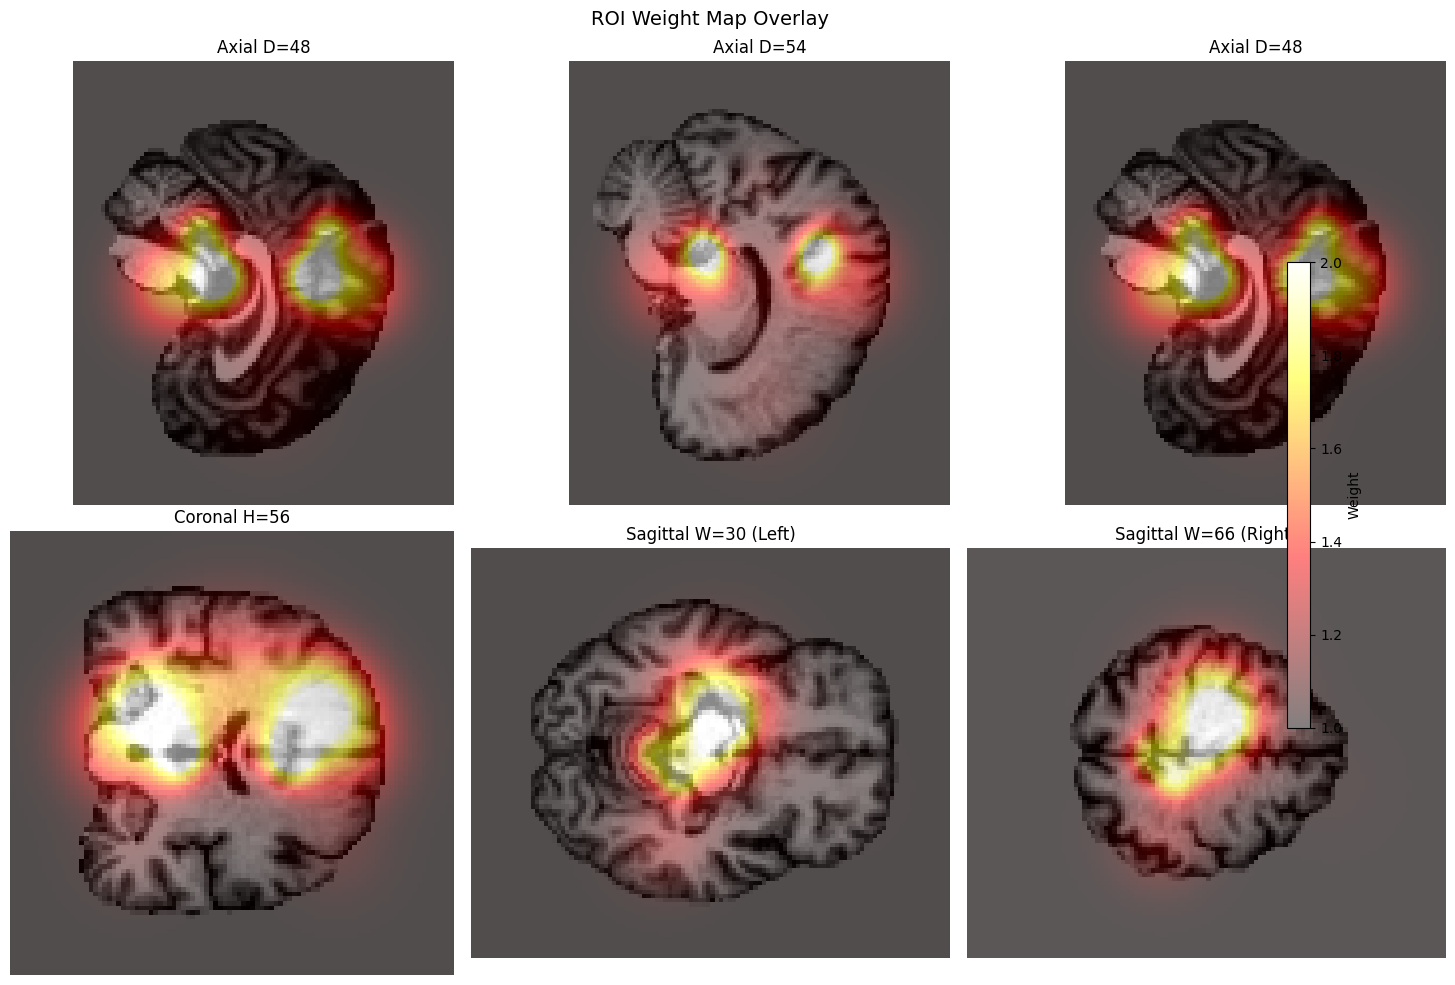

In [13]:
# 🎯 ROI 가중치 맵 시각화
import matplotlib.pyplot as plt

if ROIConfig.USE_ROI_ATTENTION:
    wm = create_roi_weight_map(
        Config.TARGET_SHAPE,
        ROIConfig.ROI_DEFINITIONS,
        ROIConfig.BASE_WEIGHT
    )[0, 0].numpy()

    # 샘플 1개 로드
    sample_ds = NiftiDataset(
        splits['train'].iloc[:1].reset_index(drop=True),
        target_shape=Config.TARGET_SHAPE,
        augment=False
    )
    vol, label = sample_ds[0]
    vol_np = vol[0].numpy()

    d, h, w = vol_np.shape

    # 주요 ROI 위치에서 슬라이스
    # 해마 높이 (D=38), 엔토라이날 높이 (D=32), 후대상피질 높이 (D=55)
    slices_d = [48, 54, 48]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 상단: Axial slices at key ROI depths
    for i, d_idx in enumerate(slices_d):
        axes[0, i].imshow(vol_np[d_idx, :, :], cmap='gray')
        im = axes[0, i].imshow(wm[d_idx, :, :], cmap='hot', alpha=0.5, vmin=1.0, vmax=2.0)
        axes[0, i].set_title(f'Axial D={d_idx}')
        axes[0, i].axis('off')

    # 하단: Coronal, Sagittal at center
    axes[1, 0].imshow(vol_np[:, h//2, :], cmap='gray')
    axes[1, 0].imshow(wm[:, h//2, :], cmap='hot', alpha=0.5, vmin=1.0, vmax=2.0)
    axes[1, 0].set_title(f'Coronal H={h//2}')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(vol_np[:, :, 30], cmap='gray')  # Left hemisphere
    axes[1, 1].imshow(wm[:, :, 30], cmap='hot', alpha=0.5, vmin=1.0, vmax=2.0)
    axes[1, 1].set_title('Sagittal W=30 (Left)')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(vol_np[:, :, 66], cmap='gray')  # Right hemisphere
    axes[1, 2].imshow(wm[:, :, 66], cmap='hot', alpha=0.5, vmin=1.0, vmax=2.0)
    axes[1, 2].set_title('Sagittal W=66 (Right)')
    axes[1, 2].axis('off')

    plt.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02, label='Weight')
    plt.suptitle('ROI Weight Map Overlay', fontsize=14)
    plt.tight_layout()
    plt.savefig(Config.OUTPUT_DIR / 'roi_weight_map.png', dpi=150)
    plt.show()
else:
    print('ROI attention disabled.')

In [14]:
# 모델 생성
roi_attention = build_roi_attention(Config, ROIConfig)

model_name = str(Config.MODEL_NAME).lower().replace(" ", "")

if model_name == "attention":
    model = MCIClassifierWithAttention(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "transformer":
    model = MCIClassifierCNNTransformer(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "lstm":
    model = MCIClassifierCNNLSTM(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "gru":
    model = MCIClassifierCNNGRU(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "translstm":
    model = MCIClassifierTransLSTM(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "transgru":
    model = MCIClassifierTransGRU(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
elif model_name == "basic":
    model = MCIClassifier3D(
        num_classes=Config.NUM_CLASSES,
        dropout=Config.DROPOUT,
        roi_attention=roi_attention
    )
else:
    raise ValueError(f"Unsupported MODEL_NAME: {Config.MODEL_NAME}")

model.to(Config.DEVICE)

# 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {Config.MODEL_NAME}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"ROI Attention: {'Enabled' if roi_attention else 'Disabled'}")

Model: attention
Total parameters: 3,547,042
Trainable parameters: 3,547,042
ROI Attention: Enabled


In [15]:
# 학습 실행
history = train(
    model=model,
    loaders=loaders,
    device=Config.DEVICE,
    epochs=Config.EPOCHS,
    lr=Config.LR,
    output_dir=Config.OUTPUT_DIR,
    early_stop_patience=Config.EARLY_STOP_PATIENCE,
    grad_accum_steps=Config.GRAD_ACCUM_STEPS,
    num_classes=Config.NUM_CLASSES,
)

# History 저장
with open(Config.OUTPUT_DIR / "history.json", "w") as f:
    json.dump(history, f, indent=2)

Epoch 1/20: 100%|██████████| 64/64 [22:35<00:00, 21.19s/it, loss=0.7115, grad_norm=0.367]



Epoch 1/20
  Train Loss: 0.6914
  Grad Norm - Avg: 0.530 | Max: 1.503
  Val - Acc: 0.6696 | F1(macro): 0.5291 | AUC(macro): nan
  Per-class F1 - CN: 0.2718 | CI: 0.7863
  Confusion Matrix:
[[ 14  69]
 [  6 138]]
  ✓ New best model saved (F1 macro: 0.5291)


Epoch 2/20: 100%|██████████| 64/64 [02:42<00:00,  2.54s/it, loss=0.6740, grad_norm=0.905]



Epoch 2/20
  Train Loss: 0.6791
  Grad Norm - Avg: 0.443 | Max: 0.905
  Val - Acc: 0.6344 | F1(macro): 0.4296 | AUC(macro): nan
  Per-class F1 - CN: 0.0879 | CI: 0.7713
  Confusion Matrix:
[[  4  79]
 [  4 140]]


Epoch 3/20: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it, loss=0.6674, grad_norm=0.455]



Epoch 3/20
  Train Loss: 0.6693
  Grad Norm - Avg: 0.551 | Max: 0.857
  Val - Acc: 0.7841 | F1(macro): 0.7552 | AUC(macro): nan
  Per-class F1 - CN: 0.6711 | CI: 0.8393
  Confusion Matrix:
[[ 50  33]
 [ 16 128]]
  ✓ New best model saved (F1 macro: 0.7552)


Epoch 4/20: 100%|██████████| 64/64 [02:26<00:00,  2.29s/it, loss=0.6497, grad_norm=0.933]



Epoch 4/20
  Train Loss: 0.6500
  Grad Norm - Avg: 0.689 | Max: 0.942
  Val - Acc: 0.7885 | F1(macro): 0.7684 | AUC(macro): nan
  Per-class F1 - CN: 0.7000 | CI: 0.8367
  Confusion Matrix:
[[ 56  27]
 [ 21 123]]
  ✓ New best model saved (F1 macro: 0.7684)


Epoch 5/20: 100%|██████████| 64/64 [02:29<00:00,  2.33s/it, loss=0.6131, grad_norm=0.825]



Epoch 5/20
  Train Loss: 0.6323
  Grad Norm - Avg: 0.921 | Max: 1.258
  Val - Acc: 0.7709 | F1(macro): 0.7607 | AUC(macro): nan
  Per-class F1 - CN: 0.7111 | CI: 0.8102
  Confusion Matrix:
[[ 64  19]
 [ 33 111]]


Epoch 6/20: 100%|██████████| 64/64 [02:45<00:00,  2.59s/it, loss=0.6076, grad_norm=1.540]



Epoch 6/20
  Train Loss: 0.6167
  Grad Norm - Avg: 1.290 | Max: 2.686
  Val - Acc: 0.7841 | F1(macro): 0.7722 | AUC(macro): nan
  Per-class F1 - CN: 0.7200 | CI: 0.8244
  Confusion Matrix:
[[ 63  20]
 [ 29 115]]
  ✓ New best model saved (F1 macro: 0.7722)


Epoch 7/20: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it, loss=0.7179, grad_norm=2.808]



Epoch 7/20
  Train Loss: 0.6005
  Grad Norm - Avg: 1.412 | Max: 2.808
  Val - Acc: 0.8062 | F1(macro): 0.8003 | AUC(macro): nan
  Per-class F1 - CN: 0.7660 | CI: 0.8346
  Confusion Matrix:
[[ 72  11]
 [ 33 111]]
  ✓ New best model saved (F1 macro: 0.8003)


Epoch 8/20: 100%|██████████| 64/64 [02:36<00:00,  2.45s/it, loss=0.6115, grad_norm=3.234]



Epoch 8/20
  Train Loss: 0.5877
  Grad Norm - Avg: 1.574 | Max: 3.234
  Val - Acc: 0.7004 | F1(macro): 0.7004 | AUC(macro): nan
  Per-class F1 - CN: 0.6991 | CI: 0.7018
  Confusion Matrix:
[[79  4]
 [64 80]]


Epoch 9/20: 100%|██████████| 64/64 [02:29<00:00,  2.33s/it, loss=0.5502, grad_norm=1.867]



Epoch 9/20
  Train Loss: 0.5783
  Grad Norm - Avg: 1.453 | Max: 2.255
  Val - Acc: 0.7797 | F1(macro): 0.7766 | AUC(macro): nan
  Per-class F1 - CN: 0.7500 | CI: 0.8031
  Confusion Matrix:
[[ 75   8]
 [ 42 102]]


Epoch 10/20: 100%|██████████| 64/64 [02:34<00:00,  2.41s/it, loss=0.4831, grad_norm=1.229]



Epoch 10/20
  Train Loss: 0.5622
  Grad Norm - Avg: 1.845 | Max: 4.540
  Val - Acc: 0.6740 | F1(macro): 0.6737 | AUC(macro): nan
  Per-class F1 - CN: 0.6838 | CI: 0.6636
  Confusion Matrix:
[[80  3]
 [71 73]]


Epoch 11/20: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it, loss=0.5775, grad_norm=2.435]



Epoch 11/20
  Train Loss: 0.5530
  Grad Norm - Avg: 1.875 | Max: 3.126
  Val - Acc: 0.7137 | F1(macro): 0.7136 | AUC(macro): nan
  Per-class F1 - CN: 0.7111 | CI: 0.7162
  Confusion Matrix:
[[80  3]
 [62 82]]


Epoch 12/20: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it, loss=0.5357, grad_norm=1.244]



Epoch 12/20
  Train Loss: 0.5567
  Grad Norm - Avg: 1.732 | Max: 2.989
  Val - Acc: 0.7137 | F1(macro): 0.7137 | AUC(macro): nan
  Per-class F1 - CN: 0.7137 | CI: 0.7137
  Confusion Matrix:
[[81  2]
 [63 81]]


Epoch 13/20: 100%|██████████| 64/64 [02:37<00:00,  2.46s/it, loss=0.5501, grad_norm=4.699]



Epoch 13/20
  Train Loss: 0.5416
  Grad Norm - Avg: 2.159 | Max: 4.699
  Val - Acc: 0.6916 | F1(macro): 0.6911 | AUC(macro): nan
  Per-class F1 - CN: 0.7034 | CI: 0.6789
  Confusion Matrix:
[[83  0]
 [70 74]]


Epoch 14/20: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it, loss=0.5323, grad_norm=2.916]



Epoch 14/20
  Train Loss: 0.5400
  Grad Norm - Avg: 2.213 | Max: 4.160
  Val - Acc: 0.6828 | F1(macro): 0.6821 | AUC(macro): nan
  Per-class F1 - CN: 0.6975 | CI: 0.6667
  Confusion Matrix:
[[83  0]
 [72 72]]


Epoch 15/20: 100%|██████████| 64/64 [02:33<00:00,  2.40s/it, loss=0.5299, grad_norm=3.071]



Epoch 15/20
  Train Loss: 0.5476
  Grad Norm - Avg: 2.560 | Max: 3.666
  Val - Acc: 0.7753 | F1(macro): 0.7736 | AUC(macro): nan
  Per-class F1 - CN: 0.7536 | CI: 0.7935
  Confusion Matrix:
[[78  5]
 [46 98]]


Epoch 16/20: 100%|██████████| 64/64 [02:35<00:00,  2.43s/it, loss=0.5048, grad_norm=1.549]



Epoch 16/20
  Train Loss: 0.5432
  Grad Norm - Avg: 2.050 | Max: 3.988
  Val - Acc: 0.7797 | F1(macro): 0.7785 | AUC(macro): nan
  Per-class F1 - CN: 0.7619 | CI: 0.7951
  Confusion Matrix:
[[80  3]
 [47 97]]


Epoch 17/20: 100%|██████████| 64/64 [02:25<00:00,  2.28s/it, loss=0.4927, grad_norm=3.739]



Epoch 17/20
  Train Loss: 0.5271
  Grad Norm - Avg: 2.533 | Max: 4.540
  Val - Acc: 0.7665 | F1(macro): 0.7656 | AUC(macro): nan
  Per-class F1 - CN: 0.7512 | CI: 0.7801
  Confusion Matrix:
[[80  3]
 [50 94]]


Epoch 18/20: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it, loss=0.6602, grad_norm=1.238]



Epoch 18/20
  Train Loss: 0.5422
  Grad Norm - Avg: 1.998 | Max: 3.258
  Val - Acc: 0.7489 | F1(macro): 0.7484 | AUC(macro): nan
  Per-class F1 - CN: 0.7373 | CI: 0.7595
  Confusion Matrix:
[[80  3]
 [54 90]]


Epoch 19/20: 100%|██████████| 64/64 [02:26<00:00,  2.28s/it, loss=0.5071, grad_norm=1.385]



Epoch 19/20
  Train Loss: 0.5217
  Grad Norm - Avg: 2.073 | Max: 4.341
  Val - Acc: 0.7797 | F1(macro): 0.7785 | AUC(macro): nan
  Per-class F1 - CN: 0.7619 | CI: 0.7951
  Confusion Matrix:
[[80  3]
 [47 97]]


Epoch 20/20: 100%|██████████| 64/64 [02:22<00:00,  2.23s/it, loss=0.5346, grad_norm=2.561]



Epoch 20/20
  Train Loss: 0.5246
  Grad Norm - Avg: 1.776 | Max: 2.561
  Val - Acc: 0.7797 | F1(macro): 0.7785 | AUC(macro): nan
  Per-class F1 - CN: 0.7619 | CI: 0.7951
  Confusion Matrix:
[[80  3]
 [47 97]]


In [ ]:
# 테스트 평가
checkpoint = torch.load(Config.OUTPUT_DIR / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
test_metrics = evaluate(model, loaders["test"], Config.DEVICE, Config.NUM_CLASSES)
test_cm = compute_confusion_matrix(model, loaders["test"], Config.DEVICE, Config.NUM_CLASSES)

print("=" * 60)
print("TEST RESULTS (CN vs Impaired [MCI+AD])")
print("=" * 60)
print(f"Accuracy:        {test_metrics['accuracy']:.4f}")
print(f"F1 (macro):      {test_metrics['f1_macro']:.4f}")
print(f"F1 (weighted):   {test_metrics['f1_weighted']:.4f}")
print(f"Precision(macro):{test_metrics['precision_macro']:.4f}")
print(f"Recall(macro):   {test_metrics['recall_macro']:.4f}")
print(f"AUC (macro):     {test_metrics['auc_macro']:.4f}")
print("-" * 60)
print("Per-class metrics:")
for name in Config.CLASS_NAMES:
    print(f"  {name:>3} - Precision: {test_metrics[f'precision_{name}']:.4f} | "
          f"Recall: {test_metrics[f'recall_{name}']:.4f} | "
          f"F1: {test_metrics[f'f1_{name}']:.4f}")
print("-" * 60)
print(f"Confusion Matrix:")
header = " " * 10 + " ".join(
    f"{('Pred ' + name):>8}" for name in Config.CLASS_NAMES
)
print(header)
for i, name in enumerate(Config.CLASS_NAMES):
    row = " ".join(f"{test_cm[i, j]:>8}" for j in range(len(Config.CLASS_NAMES)))
    print(f"True {name:>3}   {row}")
for i, name in enumerate(Config.CLASS_NAMES):
    print(f"True {name:>3}   {test_cm[i,0]:>8} {test_cm[i,1]:>9} {test_cm[i,2]:>8}")
print("=" * 60)

# 결과 저장
with open(Config.OUTPUT_DIR / "test_results.json", "w") as f:
    json.dump({
        "metrics": test_metrics,
        "confusion_matrix": test_cm.tolist()
    }, f, indent=2)

---
## 🔍 CAM 시각화 (Original / Grad-CAM / Pixel-Gradient / PCG-CAM)

In [ ]:
import matplotlib.pyplot as plt


def _resolve_target_layer(model: nn.Module) -> nn.Module:
    if hasattr(model, 'encoder'):
        return model.encoder[-1].block[3]
    if hasattr(model, 'block4'):
        return model.block4.block[3]
    if hasattr(model, 'layer4'):
        return model.layer4
    raise RuntimeError('Grad-CAM target layer not found')


class GradCAM3D:
    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._handles = []

        def forward_hook(_, __, output):
            self.activations = output

        def backward_hook(_, grad_in, grad_out):
            self.gradients = grad_out[0]

        self._handles.append(target_layer.register_forward_hook(forward_hook))
        self._handles.append(target_layer.register_full_backward_hook(backward_hook))

    def remove(self) -> None:
        for h in self._handles:
            h.remove()
        self._handles = []

    def __call__(self, x: torch.Tensor, class_idx: int | None = None) -> torch.Tensor:
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1)[0])
        score = logits[:, class_idx].sum()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3, 4), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam


def compute_pixel_gradient(model: nn.Module, x: torch.Tensor, class_idx: int) -> np.ndarray:
    """Pixel-Gradient CAM: 입력 픽셀에 대한 출력 gradient"""
    model.zero_grad(set_to_none=True)
    x_input = x.clone().detach().requires_grad_(True)
    logits = model(x_input)
    score = logits[:, class_idx].sum()
    score.backward()

    grad = x_input.grad.detach().cpu().numpy()[0, 0]  # (D, H, W)
    # 절대값 → 정규화
    grad = np.abs(grad)
    grad = grad - grad.min()
    grad = grad / (grad.max() + 1e-6)
    return grad


def compute_pcg_cam(grad_cam_np: np.ndarray, pixel_grad_np: np.ndarray) -> np.ndarray:
    """PCG-CAM: Grad-CAM × Pixel-Gradient (element-wise product)"""
    pcg = grad_cam_np * pixel_grad_np
    pcg = pcg - pcg.min()
    pcg = pcg / (pcg.max() + 1e-6)
    return pcg


def compute_roi_abnormality(activation_map: np.ndarray, roi_definitions: dict) -> list[dict]:
    """ROI별 abnormality score 계산 (0~1)."""
    D, H, W = activation_map.shape
    d = np.arange(D, dtype=np.float32)
    h = np.arange(H, dtype=np.float32)
    w = np.arange(W, dtype=np.float32)
    dd, hh, ww = np.meshgrid(d, h, w, indexing='ij')

    results = []
    for name, roi in roi_definitions.items():
        center = roi["center"]
        sigma = float(roi["sigma"])
        dist_sq = (dd - center[0])**2 + (hh - center[1])**2 + (ww - center[2])**2
        mask = np.exp(-dist_sq / (2 * sigma**2))
        score = float((activation_map * mask).sum() / (mask.sum() + 1e-6))
        results.append({
            "name": name,
            "description": roi.get("description", ""),
            "score": score,
        })
    return results


# ============================================================
# 양성 클래스 예측 성공 샘플 찾기 (True=POS, Pred=POS)
# ============================================================
POS_LABEL = 1
POS_NAME = Config.CLASS_NAMES[POS_LABEL]

model.eval()
test_ds = NiftiDataset(splits["test"], target_shape=Config.TARGET_SHAPE, augment=False)

pos_correct_indices = []
pos_correct_probs = []

print(f"{POS_NAME} 예측 성공 샘플 탐색 중...")
with torch.no_grad():
    for idx in range(len(test_ds)):
        vol, label = test_ds[idx]
        if label != POS_LABEL:
            continue
        vol_input = vol.unsqueeze(0).to(Config.DEVICE)
        logits = model(vol_input)
        pred = int(torch.argmax(logits, dim=1)[0])
        if pred == POS_LABEL:
            prob = float(torch.softmax(logits, dim=1)[0, POS_LABEL].cpu().item())
            pos_correct_indices.append(idx)
            pos_correct_probs.append(prob)

print(f"{POS_NAME} 예측 성공 샘플 수: {len(pos_correct_indices)}")

if len(pos_correct_indices) == 0:
    print(f"{POS_NAME} 예측 성공 샘플이 없습니다.")
else:
    # 양성 클래스 확률이 가장 높은 샘플 선택
    best_idx = pos_correct_indices[np.argmax(pos_correct_probs)]
    best_prob = max(pos_correct_probs)
    subject_id = splits["test"].iloc[best_idx]["subject_id"]
    print(f"선택 샘플 - Subject: {subject_id}, {POS_NAME} prob: {best_prob*100:.1f}%")

    vol, label = test_ds[best_idx]
    vol_input = vol.unsqueeze(0).to(Config.DEVICE)

    with torch.no_grad():
        logits = model(vol_input)
        probs = torch.softmax(logits, dim=1)

    # --- 1) Grad-CAM ---
    target_layer = _resolve_target_layer(model)
    cam_gen = GradCAM3D(model, target_layer)
    cam = cam_gen(vol_input, class_idx=POS_LABEL)
    cam_gen.remove()
    cam_up = F.interpolate(cam, size=Config.TARGET_SHAPE, mode='trilinear', align_corners=False)
    gradcam_np = cam_up.detach().cpu().numpy()[0, 0]

    # --- 2) Pixel-Gradient CAM ---
    pixgrad_np = compute_pixel_gradient(model, vol_input, class_idx=POS_LABEL)

    # Pixel-Gradient 최대 활성 좌표
    pixgrad_max_pos = np.unravel_index(pixgrad_np.argmax(), pixgrad_np.shape)
    print(f"Pixel-Gradient 최대 활성 좌표 (D, H, W): {pixgrad_max_pos}")

    # ROI 기반 이상 부위 Top-5 (Pixel-Gradient 기준)
    roi_scores = compute_roi_abnormality(pixgrad_np, ROIConfig.ROI_DEFINITIONS)
    roi_scores = sorted(roi_scores, key=lambda x: x["score"], reverse=True)
    print("ROI 이상 부위 Top-5 (Pixel-Gradient 기준)")
    for rank, item in enumerate(roi_scores[:5], start=1):
        pct = item["score"] * 100.0
        desc = f" - {item['description']}" if item["description"] else ""
        print(f"  {rank}. {item['name']}{desc}: {pct:.2f}%")

    # --- 3) PCG-CAM ---
    pcg_np = compute_pcg_cam(gradcam_np, pixgrad_np)

    vol_np = vol_input.detach().cpu().numpy()[0, 0]

    # ============================================================
    # CAM 종류별: 최대 활성 좌표 기준으로 원본 vs CAM 나란히 표시
    # ============================================================
    def _plot_cam_max_activation(cam_name: str, cam_np: np.ndarray, vol_np: np.ndarray, max_pos: tuple[int, int, int]) -> None:
        view_slices = [
            ("Axial",    max_pos[0], lambda v, i: v[i, :, :]),
            ("Coronal",  max_pos[1], lambda v, i: v[:, i, :]),
            ("Sagittal", max_pos[2], lambda v, i: v[:, :, i]),
        ]

        fig, axes = plt.subplots(3, 2, figsize=(10, 12))

        for row, (view_name, slice_idx, slicer) in enumerate(view_slices):
            base = slicer(vol_np, slice_idx)

            ax0 = axes[row, 0]
            ax0.imshow(base, cmap='gray')
            if row == 0:
                ax0.set_title("Original", fontsize=12, fontweight='bold')
            ax0.set_ylabel(f"{view_name}\\n(slice={slice_idx})", fontsize=11)
            ax0.set_xticks([])
            ax0.set_yticks([])

            ax1 = axes[row, 1]
            ax1.imshow(base, cmap='gray')
            heat = slicer(cam_np, slice_idx)
            im = ax1.imshow(heat, cmap='turbo', alpha=0.55, vmin=0.0, vmax=1.0)
            if row == 0:
                ax1.set_title(cam_name, fontsize=12, fontweight='bold')
            ax1.set_xticks([])
            ax1.set_yticks([])

        # colorbar
        cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, label='Activation')

        prob_str = " | ".join(f"{n}: {probs[0, i].cpu().item()*100:.1f}%" for i, n in enumerate(Config.CLASS_NAMES))
        fig.suptitle(
            f"[Positive Correct] Subject: {subject_id}  |  True: {POS_NAME}  |  Pred: {POS_NAME} ({best_prob*100:.1f}%)\\n"
            f"[{prob_str}]  |  {cam_name} Max activation (D={max_pos[0]}, H={max_pos[1]}, W={max_pos[2]})",
            y=0.98, fontsize=11
        )
        plt.subplots_adjust(wspace=0.02, hspace=0.08, right=0.88)
        safe_name = re.sub(r"[^a-z0-9]+", "_", cam_name.lower()).strip("_")
        plt.savefig(Config.OUTPUT_DIR / f"{safe_name}_max_activation.png", dpi=150, bbox_inches='tight')
        plt.show()

    gradcam_max_pos = np.unravel_index(gradcam_np.argmax(), gradcam_np.shape)
    pixgrad_max_pos = np.unravel_index(pixgrad_np.argmax(), pixgrad_np.shape)
    pcg_max_pos = np.unravel_index(pcg_np.argmax(), pcg_np.shape)

    cam_items = [
        ("Grad-CAM", gradcam_np, gradcam_max_pos),
        ("Pixel-Gradient", pixgrad_np, pixgrad_max_pos),
        ("PCG-CAM", pcg_np, pcg_max_pos),
    ]

    for cam_name, cam_np, max_pos in cam_items:
        print(f"{cam_name} 최대 활성 좌표 (D, H, W): {max_pos}")
        _plot_cam_max_activation(cam_name, cam_np, vol_np, max_pos)
